In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from bs4 import BeautifulSoup
import requests
sns.set_style('white')
from IPython.display import HTML

In [2]:
pd.set_option('display.large_repr', 'truncate')
pd.set_option('display.max_columns', 0)

In [26]:
f = open("Downloads/listings.csv")
data = pd.read_csv(f)
data.loc[0:3]
#data.fillna(0)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,7087327,https://www.airbnb.com/rooms/7087327,20151002231825,2015-10-03,Historic DC Condo-Walk to Capitol!,"Professional pictures coming soon! Welcome to Hill Flats. Enjoy being across the street from the Library of Congress, short walk to US Capitol, museums and Union Station. Restaurants and bars a few blocks from our peaceful neighborhood.",NaN,"Professional pictures coming soon! Welcome to Hill Flats. Enjoy being across the street from the Library of Congress, short walk to US Capitol, museums and Union Station. Restaurants and bars a few blocks from our peaceful neighborhood.",none,NaN,NaN,NaN,https://a2.muscache.com/ac/pictures/105507202/95c4d33f_original.jpg?interpolation=lanczos-none&size=small&output-format=jpg&output-quality=70,https://a2.muscache.com/im/pictures/105507202/95c4d33f_original.jpg?aki_policy=medium,https://a2.muscache.com/ac/pictures/105507202/95c4d33f_original.jpg?interpolation=lanczos-none&size=large_cover&output-format=jpg&output-quality=70,https://a2.muscache.com/ac/pictures/105507202/95c4d33f_original.jpg?interpolation=lanczos-none&size=x_large_cover&output-format=jpg&output-quality=70,15830506,https://www.airbnb.com/users/show/15830506,Lize & Greg,2014-05-21,"Washington, District of Columbia, United States","We are two fun, friendly entrepreneurs living in DC/Philadelphia. We love to travel and meet people from all over the world. Our listings are in the best locations in and around the city. Being the lovers of travel that we are, we pride ourselves on providing the best guest experience and making your stay memorable :-D\n\nYou may speak with Greg, Lize, or Lyuba (pronounced ""Lu-ba"") at some point during your stay.\nLyuba is a great friend of ours since childhood that helps us with making sure your check-in is smooth, and you are satisfied during the duration of your stay.\n\nPlease help us help you the best we can by providing inquiries with the following information:\n\n1) Name, number of guests, and your reason for staying.\n\n2) Desired check-in time and check-out time\n(we will do o...",within a few hours,92%,91%,f,"https://a1.muscache.com/ac/users/15830506/profile_pic/1409082919/original.jpg?interpolation=lanczos-none&crop=w:w;*,*&crop=h:h;*,*&resize=50:*&output-format=jpg&output-quality=70","https://a1.muscache.com/ac/users/15830506/profile_pic/1409082919/original.jpg?interpolation=lanczos-none&crop=w:w;*,*&crop=h:h;*,*&resize=225:*&output-format=jpg&output-quality=70",Truxton Circle,26,26,"['email', 'phone', 'facebook', 'google', 'reviews', 'kba']",t,t,"3rd Street Southeast, Washington, DC 20003, United States",Capitol Hill

# Web-scrapping using BeautifulSoup

In [7]:
# 1. Download webpage
page = requests.get("http://forecast.weather.gov/MapClick.php?lat=37.7772&lon=-122.4168#.Wkdt5yOp2OE")

In [8]:
# 2. Create a BeautifulSoup instance to parse the page
soup = BeautifulSoup(page.content, 'html.parser')

In [9]:
# 3. Find the div with info needed. Use 'find' or 'find_all'
seven_day = soup.find(id = "seven-day-forecast")

In [18]:
# 4. Inside seven_day, find each individual forecast item
forecast_items = seven_day.find_all(class_= "tombstone-container")
print(forecast_items[0])

<div class="tombstone-container">
<p class="period-name">Overnight<br/><br/></p>
<p><img alt="Overnight: Partly cloudy, with a low around 48. North northwest wind around 6 mph. " class="forecast-icon" src="newimages/medium/nsct.png" title="Overnight: Partly cloudy, with a low around 48. North northwest wind around 6 mph. "/></p><p class="short-desc">Partly Cloudy</p><p class="temp temp-low">Low: 48 °F</p></div>


In [22]:
tonight = forecast_items[0]
period = tonight.find(class_="period-name").get_text()
short_desc = tonight.find(class_="short-desc").get_text()
temp = tonight.find(class_="temp").get_text()

print(period)
print(short_desc)
print(temp)

Overnight
Partly Cloudy
Low: 48 °F


In [32]:
img = tonight.find("img")
desc = img["title"]
print(desc)

Overnight: Partly cloudy, with a low around 48. North northwest wind around 6 mph. 


In [56]:
# Extract all info from div <seven-day-forecast> at once
period_tags = seven_day.select(".tombstone-container .period-name")
periods = [pt.get_text() for pt in period_tags]
print(periods)

[u'Overnight', u'Saturday', u'SaturdayNight', u'Sunday', u'SundayNight', u"NewYear'sDay", u'MondayNight', u'Tuesday', u'TuesdayNight']


In [57]:
short_desc = [sd.get_text() for sd in seven_day.select(".tombstone-container .short-desc")]
temp = [temp.get_text() for temp in seven_day.select(".tombstone-container .temp")]
desc = [title["title"] for title in seven_day.select(".tombstone-container img")]

print(short_desc)
print(temp)
print(desc)

[u'Partly Cloudy', u'Mostly Sunny', u'Partly Cloudy', u'Partly Sunny', u'Partly Cloudy', u'Partly Sunny', u'Mostly Cloudy', u'Slight ChanceRain', u'Slight ChanceRain']
[u'Low: 48 \xb0F', u'High: 59 \xb0F', u'Low: 49 \xb0F', u'High: 59 \xb0F', u'Low: 52 \xb0F', u'High: 60 \xb0F', u'Low: 50 \xb0F', u'High: 59 \xb0F', u'Low: 51 \xb0F']
[u'Overnight: Partly cloudy, with a low around 48. North northwest wind around 6 mph. ', u'Saturday: Mostly sunny, with a high near 59. North wind around 8 mph. ', u'Saturday Night: Partly cloudy, with a low around 49. North wind 5 to 7 mph. ', u'Sunday: Partly sunny, with a high near 59. Southwest wind 6 to 11 mph. ', u'Sunday Night: Partly cloudy, with a low around 52. West southwest wind 8 to 13 mph. ', u"New Year's Day: Partly sunny, with a high near 60.", u'Monday Night: Mostly cloudy, with a low around 50.', u'Tuesday: A slight chance of rain.  Partly sunny, with a high near 59.', u'Tuesday Night: A slight chance of rain.  Mostly cloudy, with a low ar

In [3]:
weather = pd.DataFrame({
    "period": periods,
    "short_desc": short_desc,
    "temp": temp,
    "desc": desc
})
weather

NameError: name 'periods' is not defined

In [64]:
# Handling data from Dataframe
temp_nums = weather["temp"].str.extract("(?P<temp_num>\d+)", expand=False)
weather["temp_num"] = temp_nums.astype('int')
temp_nums

0    48
1    59
2    49
3    59
4    52
5    60
6    50
7    59
8    51
Name: temp_num, dtype: object

In [60]:
weather

,desc,period,short_desc,temp,temp_num
0,"Overnight: Partly cloudy, with a low around 48...",Overnight,Partly Cloudy,Low: 48 °F,48
1,"Saturday: Mostly sunny, with a high near 59. N...",Saturday,Mostly Sunny,High: 59 °F,59
2,"Saturday Night: Partly cloudy, with a low arou...",SaturdayNight,Partly Cloudy,Low: 49 °F,49
3,"Sunday: Partly sunny, with a high near 59. Sou...",Sunday,Partly Sunny,High: 59 °F,59
4,"Sunday Night: Partly cloudy, with a low around...",SundayNight,Partly Cloudy,Low: 52 °F,52
5,"New Year's Day: Partly sunny, with a high near...",NewYear'sDay,Partly Sunny,High: 60 °F,60
6,"Monday Night: Mostly cloudy, with a low around...",MondayNight,Mostly Cloudy,Low: 50 °F,50
7,Tuesday: A slight chance of rain. Partly sunn...,Tuesday,Slight ChanceRain,High: 59 °F,59
8,Tuesday Night: A slight chance of rain. Mostl...,TuesdayNight,Slight ChanceRain,Low: 51 °F,51


In [65]:
weather["temp_num"].mean()

54.111111111111114

In [66]:
is_night = weather["temp"].str.contains("Low")
weather["is_night"] = is_night
is_night

0     True
1    False
2     True
3    False
4     True
5    False
6     True
7    False
8     True
Name: temp, dtype: bool

In [67]:
weather[is_night]

,desc,period,short_desc,temp,temp_num,is_night
0,"Overnight: Partly cloudy, with a low around 48...",Overnight,Partly Cloudy,Low: 48 °F,48,True
2,"Saturday Night: Partly cloudy, with a low arou...",SaturdayNight,Partly Cloudy,Low: 49 °F,49,True
4,"Sunday Night: Partly cloudy, with a low around...",SundayNight,Partly Cloudy,Low: 52 °F,52,True
6,"Monday Night: Mostly cloudy, with a low around...",MondayNight,Mostly Cloudy,Low: 50 °F,50,True
8,Tuesday Night: A slight chance of rain. Mostl...,TuesdayNight,Slight ChanceRain,Low: 51 °F,51,True


In [4]:
pt = pd.read_csv('data.csv')

In [5]:
pt.describe()

,Unnamed: 0,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
count,495.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,495.000000
mean,247.000000,78.829787,5.370728,0.927830,0.990347,0.579968,0.402828,0.134790,0.242241,2.092717,2016.000000
std,143.038456,45.281408,1.136998,0.415584,0.318707,0.240161,0.150356,0.111313,0.131543,0.565772,0.817323
min,0.000000,1.000000,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328580,2015.000000
25%,123.500000,40.000000,4.509000,0.605292,0.793000,0.402301,0.297615,0.059777,0.152831,1.737975,2015.000000
50%,247.000000,79.000000,5.282500,0.995439,1.025665,0.630053,0.418347,0.099502,0.223140,2.094640,2016.000000
75%,370.500000,118.000000,6.233750,1.252443,1.228745,0.768298,0.516850,0.173161,0.315824,2.455575,2017.000000
max,494.000000,158.000000,7.587000,1.870766,1.610574,1.025250,0.669730,0.551910,0.838075,3.837720,2017.000000


In [6]:
pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 13 columns):
Unnamed: 0                       495 non-null int64
Country                          495 non-null object
Region                           495 non-null object
Happiness Rank                   470 non-null float64
Happiness Score                  470 non-null float64
Economy (GDP per Capita)         470 non-null float64
Family                           470 non-null float64
Health (Life Expectancy)         470 non-null float64
Freedom                          470 non-null float64
Trust (Government Corruption)    470 non-null float64
Generosity                       470 non-null float64
Dystopia Residual                470 non-null float64
Year                             495 non-null int64
dtypes: float64(9), int64(2), object(2)
memory usage: 50.4+ KB


In [10]:
pt.head(5)

,Unnamed: 0,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
0,0,Afghanistan,Southern Asia,153.0,3.575,0.31982,0.30285,0.30335,0.23414,0.09719,0.36510,1.95210,2015
1,1,Albania,Central and Eastern Europe,95.0,4.959,0.87867,0.80434,0.81325,0.35733,0.06413,0.14272,1.89894,2015
2,2,Algeria,Middle East and Northern Africa,68.0,5.605,0.93929,1.07772,0.61766,0.28579,0.17383,0.07822,2.43209,2015
3,3,Angola,Sub-Saharan Africa,137.0,4.033,0.75778,0.86040,0.16683,0.10384,0.07122,0.12344,1.94939,2015
4,4,Argentina,Latin America and Caribbean,30.0,6.574,1.05351,1.24823,0.78723,0.44974,0.08484,0.11451,2.83600,2015


In [16]:
# Select only certain columns
new_pt = pt[['Country', 'Region', 'Family']]
# Drop columns
new_pt.drop(columns=['Country'])

,Region,Family
0,Southern Asia,0.302850
1,Central and Eastern Europe,0.804340
2,Middle East and Northern Africa,1.077720
3,Sub-Saharan Africa,0.860400
4,Latin America and Caribbean,1.248230
5,Central and Eastern Europe,0.777110
6,Australia and New Zealand,1.309230
7,Western Europe,1.297040
8,Central and Eastern Europe,0.937930
9,Middle East and Northern Africa,1.216240


In [22]:
pt.sort_values(['Year','Happiness Score'], ascending=[True, False], inplace=True)
pt

,Unnamed: 0,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
141,141,Switzerland,Western Europe,1.0,7.587,1.396510,1.349510,0.941430,0.665570,0.419780,0.296780,2.517380,2015
60,60,Iceland,Western Europe,2.0,7.561,1.302320,1.402230,0.947840,0.628770,0.141450,0.436300,2.702010,2015
38,38,Denmark,Western Europe,3.0,7.527,1.325480,1.360580,0.874640,0.649380,0.483570,0.341390,2.492040,2015
108,108,Norway,Western Europe,4.0,7.522,1.459000,1.330950,0.885210,0.669730,0.365030,0.346990,2.465310,2015
25,25,Canada,North America,5.0,7.427,1.326290,1.322610,0.905630,0.632970,0.329570,0.458110,2.451760,2015
46,46,Finland,Western Europe,6.0,7.406,1.290250,1.318260,0.889110,0.641690,0.413720,0.233510,2.619550,2015
102,102,Netherlands,Western Europe,7.0,7.378,1.329440,1.280170,0.892840,0.615760,0.318140,0.476100,2.465700,2015
140,140,Sweden,Western Europe,8.0,7.364,1.331710,1.289070,0.910870,0.659800,0.438440,0.362620,2.371190,2015
103,103,New Zealand,Australia and New Zealand,9.0,7.286,1.250180,1.319670,0.908370,0.639380,0.429220,0.475010,2.264250,2015
6,6,Australia,Australia and New Zealand,10.0,7.284,1.333580,1.309230,0.931560,0.651240,0.356370,0.435620,2.266460,2015


In [53]:
table = pt.pivot_table(index='Region', values =['Happiness Score', 'Health (Life Expectancy)'])
table

,Happiness Score,Health (Life Expectancy)
Region,,
Australia and New Zealand,7.302500,0.863789
Central and Eastern Europe,5.371184,0.662152
Eastern Asia,5.632333,0.830797
Latin America and Caribbean,6.069074,0.641650
Middle East and Northern Africa,5.387879,0.643763
North America,7.227167,0.830477
Southeastern Asia,5.364077,0.607841
Southern Asia,4.590857,0.483719
Sub-Saharan Africa,4.150957,0.249353


In [54]:
table[table.index.str.contains('Asia')]

,Happiness Score,Health (Life Expectancy)
Region,,
Eastern Asia,5.632333,0.830797
Southeastern Asia,5.364077,0.607841
Southern Asia,4.590857,0.483719


Text(0.5,1,'Happiness Score by Region')

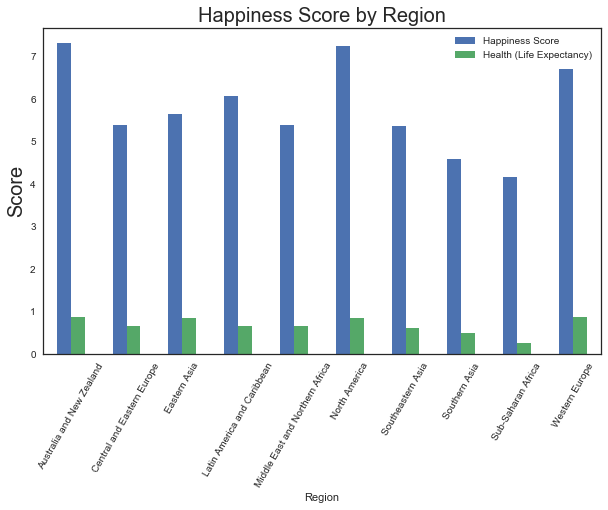

In [94]:
pt.pivot_table(index='Region', values =['Happiness Score', 'Health (Life Expectancy)']).plot(kind='bar',figsize=(10,6))
plt.xticks(rotation=60)
plt.ylabel('Score',fontsize=20)
plt.title('Happiness Score by Region', fontsize=20)

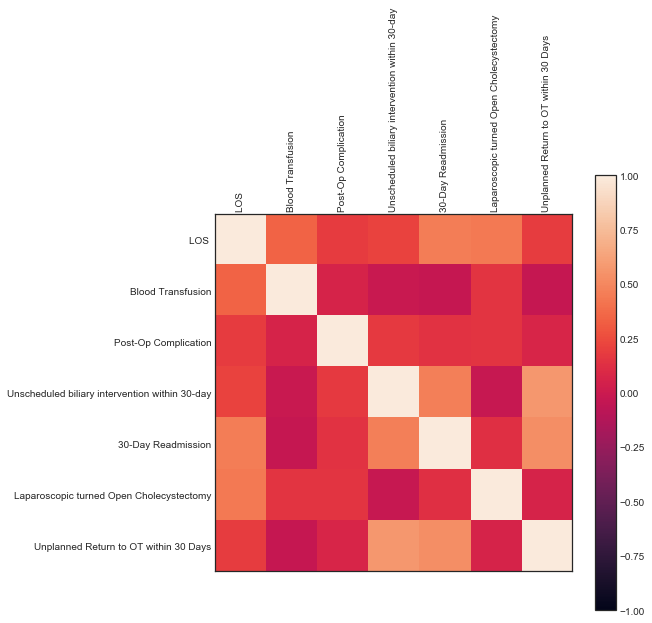

In [25]:
filename = 'Lap Chole.csv'

data = pd.read_csv(filename)
# Remove last row as LOS is large and 3 redundant columns to the right 
data = data.iloc[:-1,:-3]
# Replace column names
data.columns = ['LOS ','Blood Transfusion','Post-Op Complication',
       'Unscheduled biliary intervention within 30-day',
       '30-Day Readmission', 'ICU Transfers',
       'Laparoscopic turned Open Cholecystectomy',
       'Unplanned Return to OT within 30 Days']
# Remove column 
del data['ICU Transfers']

correlations = data.corr()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,7,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns,rotation=90)
ax.set_yticklabels(data.columns)
plt.show()

In [26]:
correlations

,LOS,Blood Transfusion,Post-Op Complication,Unscheduled biliary intervention within 30-day,30-Day Readmission,Laparoscopic turned Open Cholecystectomy,Unplanned Return to OT within 30 Days
LOS,1.000000,0.346423,0.185242,0.217168,0.460382,0.445181,0.189958
Blood Transfusion,0.346423,1.000000,0.066154,-0.014419,-0.031005,0.155701,-0.025168
Post-Op Complication,0.185242,0.066154,1.000000,0.174266,0.141841,0.152415,0.077331
Unscheduled biliary intervention within 30-day,0.217168,-0.014419,0.174266,1.000000,0.465064,-0.022192,0.572926
30-Day Readmission,0.460382,-0.031005,0.141841,0.465064,1.000000,0.127249,0.531607
Laparoscopic turned Open Cholecystectomy,0.445181,0.155701,0.152415,-0.022192,0.127249,1.000000,0.067786
Unplanned Return to OT within 30 Days,0.189958,-0.025168,0.077331,0.572926,0.531607,0.067786,1.000000


In [27]:
data

,LOS,Blood Transfusion,Post-Op Complication,Unscheduled biliary intervention within 30-day,30-Day Readmission,Laparoscopic turned Open Cholecystectomy,Unplanned Return to OT within 30 Days
0,0.35,0,0,0,0,0,0
1,0.45,0,0,0,0,0,0
2,0.89,0,0,0,0,0,0
3,0.91,0,0,0,0,0,0
4,0.94,0,0,0,0,0,0
5,0.94,0,0,0,0,0,0
6,0.95,0,0,0,0,0,0
7,0.96,0,0,0,0,0,0
8,0.96,0,0,0,0,0,0
9,0.96,0,0,0,0,0,0


In [12]:
data['New'] = pd.Series([1,0,0,1])

In [15]:
data

,LOS,Blood Transfusion,Post-Op Complication,�Unscheduled biliary intervention within 30-day�,�30-Day Readmission�,�ICU Transfers,�Laparoscopic turned Open Cholecystectomy�,�Unplanned Return to OT within 30 Days'
0,0.35,0,0,0,0,0,0,0
1,0.45,0,0,0,0,0,0,0
2,0.89,0,0,0,0,0,0,0
3,0.91,0,0,0,0,0,0,0
4,0.94,0,0,0,0,0,0,0
5,0.94,0,0,0,0,0,0,0
6,0.95,0,0,0,0,0,0,0
7,0.96,0,0,0,0,0,0,0
8,0.96,0,0,0,0,0,0,0
9,0.96,0,0,0,0,0,0,0


In [14]:
del data['New']

In [2]:
filename = 'nba_2013.csv'

data = pd.read_csv(filename)

In [3]:
data

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013
5,Cole Aldrich,C,25,NYK,46,2,330,33,61,0.541,...,92,129,14,8,30,18,40,92,2013-2014,2013
6,LaMarcus Aldridge,PF,28,POR,69,69,2498,652,1423,0.458,...,599,765,178,63,68,123,147,1603,2013-2014,2013
7,Lavoy Allen,PF,24,TOT,65,2,1072,134,300,0.447,...,192,311,71,24,33,44,126,303,2013-2014,2013
8,Ray Allen,SG,38,MIA,73,9,1936,240,543,0.442,...,182,205,143,54,8,84,115,701,2013-2014,2013
9,Tony Allen,SG,32,MEM,55,28,1278,204,413,0.494,...,129,208,94,90,19,90,121,495,2013-2014,2013


In [5]:
data.head(5)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


In [7]:
for t in data: display(data.head())

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013
